# Modelling the Learning Trajectories of the Task Switching Paradigm with ANNs

This Python notebook serves as a template for your group project for the course "Modeling in Cognitive Science".

This is the practical part of the group project where you get to implement the computational modeling workflow. In this part, you are expected to:


*   Implement at least two computational models relevant for your hypothesis. *(3 points)*
*   Simulate behavior from the two models. *(3 points)*
*   Implement a procedure for fitting the models to data. *(4 points)*
*   Implement a procedure for parameter recovery. *(5 points)*
*   (Implement a procedure for model recovery.) *(optional; 2 bonus points)*
*   Implement a model comparison. *(5 points)*.

You can gain a total of 20 points for the practical part of the group project.

**Note:** *Some of the exercises below (e.g. Model Simulation) rely on code from previous exercises (e.g., Model Implementation). In such cases, you are encouraged to rely on functions implemented for previous exercises. That is, you don't have to produce redundant code.*



## Model Implementation *(3 points)*

For this exercise you should:

*   Implement and simulate data from two* models that are suitable to test your hypothesis. *(3 points)*

<font size=2>*You may implement more than two models if you wish. However, two models are sufficient for this group project.</font>

Make sure to comment your code and provide an explanation for each code block in a preceding text block.


Import all the necesarry liberaries.

In [ ]:
# Run this cell to load the following libraries
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from copy import deepcopy

# Set the seed
random.seed(12)

In the following cell, a class is constructed for Neural Networks. Each function is decribed. The class consists of:

- Weights
-Activation Functions
- Layer activations
- Forward Pass
- Weight updates
- Initialization functions
- Data generation and simulation
- Training Model

In [ ]:
class Network:
    bias = -4
    class Weights:

        # A set of example weights that can be used if none are given, or can be used to tweak weights.

        # Weights projecting from orientation input layer to orientation hidden layer
        scale_oi_oh = 2.0
        o_in_to_o_h = scale_oi_oh * np.array([[1, -1],
                                              [-1, 1]])
        # Weights projecting from orientation hidden layer to output layer
        scale_oh_oo = 2.0
        o_h_to_out = scale_oh_oo * np.array([[1, -1],
                                             [-1, 1]])
        # Weights projecting from movement input layer to movement hidden layer
        scale_mi_mh = 2.0
        m_in_to_m_h = scale_mi_mh * np.array([[1, -1],
                                              [-1, 1]])
        # Weights projecting from movement hidden layer to output layer
        scale_mh_mo = 2.0
        m_h_to_out = scale_mh_mo * np.array([[1, -1],
                                            [-1, 1]])
        # Weights projecting from task layer to orientation hidden layer
        scale_ti_oh = 4.0
        t_in_to_o_h = scale_ti_oh * np.array([[1, 1],
                                             [0, 0]])
        # Weights projecting from task layer to movement hidden layer
        scale_ti_mh = 4.0
        t_in_to_m_h = scale_ti_mh * np.array([[0, 0],
                                              [1, 1]])

    class InitialWeights:
      # A set of weights that can be initially set.

      # Weights projecting from orientation input layer to orientation hidden layer
      scale_oi_oh = 1.0
      o_in_to_o_h = scale_oi_oh * np.array([[1, -1],
                                            [-1, 1]])
      # Weights projecting from orientation hidden layer to output layer
      scale_oh_oo = 1.0
      o_h_to_out = scale_oh_oo * np.array([[1, -1],
                                            [-1, 1]])
      # Weights projecting from movement input layer to movement hidden layer
      scale_mi_mh = 1.0
      m_in_to_m_h = scale_mi_mh * np.array([[1, -1],
                                            [-1, 1]])
      # Weights projecting from movement hidden layer to output layer
      scale_mh_mo = 1.0
      m_h_to_out = scale_mh_mo * np.array([[1, -1],
                                          [-1, 1]])
      # Weights projecting from task layer to orientation hidden layer
      scale_ti_oh = 1.0
      t_in_to_o_h = scale_ti_oh * np.array([[1, 1],
                                            [0, 0]])
      # Weights projecting from task layer to movement hidden layer
      scale_ti_mh = 1.0
      t_in_to_m_h = scale_ti_mh * np.array([[0, 0],
                                            [1, 1]])

    ### Activation Functions ###

      #The next few functions are different activation functions we are using.

    def logistic(x):

        result = 1/(1+ np.exp(-x))

        return result

    def logistic_derivative(x):

        return x * (1-x)

    def softmax(activation):

      return np.exp(activation) / np.sum(np.exp(activation))

    ### Layer activations ###

      '''
      The next part calculates the different activations of layers
      '''
    def orientation_hidden_activation(orientation_input, task_input,
                                weights, bias):

      """
      Arguments:
      orientation_input (2D array):     stores the orientation value,
                              e.g. [[1,0]] for the 0
      task_input (2D array):      stores the task value,
                              e.g. [[1,0]] for "orientation"
      weights (weights object):   collection of weights
            Allows access to weights via weights.weight_name.
                              e.g. `weights.o_in_to_o_h`
      bias (float):               A value determining the threshold for activation

      Returns:
      activation (2D array): weighted sum of all inputs processed through logistic
      """

      if weights is None:
        weights = Network.weights
      if bias is None:
        bias = Network.bias


      net_input =  np.dot(orientation_input, weights.o_in_to_o_h)
      net_input += np.dot(task_input, weights.t_in_to_o_h)
      net_input += bias

      activation = Network.logistic(net_input)


      return activation


    def movement_hidden_activation(movement_input, task_input,
                               weights, bias):

      """
      Arguments:
        movement_input (2D array):     stores the movement value,
                                    e.g. [[1,0]] for movement 0
        task_input (2D array):      stores the task value,
                                    e.g. [[0,1]] for "movement"
        weights (Weights object):   collection of weights
                  Allows access to weights via Weights.weight_name.
                                    e.g. `Weights.m_in_to_m_h`
        bias (float):               A value determining the threshold for activation

      Returns:
        activation (2D array): weighted sum of all inputs processed through logistic
      """
      if weights is None:
        weights = Network.weights
      if bias is None:
        bias = Network.bias


      net_input =  np.dot(movement_input, weights.m_in_to_m_h)
      net_input += np.dot(task_input, weights.t_in_to_m_h)
      net_input += bias

      activation = Network.logistic(net_input)


      return activation

    def output_activation(orientation_hidden_activation,
                          movement_hidden_activation,
                          weights):

      """
      Arguments:
        orientation_hidden_activation (2D array):  the activation of the hidden color layer

        movement_hidden_activation (2D array):   the activation of the hidden word layer

        weights (Weights object):   collection of weights
                  Allows access to weights via Weights.weight_name.
                                    e.g. `Weights.c_in_to_c_h`
      Returns:
        activation (2D array): weighted sum of all inputs processed through logistic
      """
      if weights is None:
        weights = Network.Weights


      net_input = np.dot(orientation_hidden_activation, weights.o_h_to_out)
      net_input += np.dot(movement_hidden_activation, weights.m_h_to_out)

      activation = Network.softmax(net_input)


      return activation


    ### Forward Pass ###

      '''
      The next part performs a forward pass.
      '''
    def forward(orientation_input, movement_input, task_input, return_activations=False,
                weights=None, bias=None):

      """
      Accepts a single input pattern for the orientation, movement and task input layers
      and produces a response probability at the output layer.

      Arguments:
        orientation_input (2D array):
        stores the orientation value (0 vs. 180); e.g [[1,0]]
        movement_input (2D array):
          stores the movement value (0 vs. 180); e.g [[1,0]]
        task_input (2D array):
          stores the task value (orientation naming vs. movement naming); e.g. [[1,0]]

      Returns:
        activation_output (2D Array):
          1x2 Array, Where the activation output corresponds to the probability of pressing left and right

      """

      if weights is None:
        weights = Network.Weights

      bias = Network.bias

      # Compute activation of color hidden layer
      activation_o_h = Network.orientation_hidden_activation(orientation_input, task_input, weights, bias)

      # Compute activation of word hidden layer
      activation_m_h = Network.movement_hidden_activation(movement_input, task_input, weights, bias)

      # Compute activation of output layer
      activation_out = Network.output_activation(activation_o_h, activation_m_h, weights)



      if return_activations:
        return {"orientation":activation_o_h,
                "movement": activation_m_h,
                "out":  activation_out}

      return activation_out


    ### WEIGHT UPDATES ####

      '''
      Here, weight updtaes are perfomed for backpropagation.
      '''
    def compute_weight_updates_hidden_to_out(hidden_activation,
                                      output_activation,
                                      error):
        """
        This function calculates the weight update for the weights
        projecting from the hidden color units to the output units.

        Arguments:
            hidden_activation (2D Array): e.g [[2,0],[0,-2]]
            output_activation: activation at the output layer
            error(float): discrepancy between output and target

        Returns:
            The weight update to be applied based on backprop
        """


        output_derivative = Network.logistic_derivative(output_activation)

        weight_update = np.dot(hidden_activation.T, error*output_derivative)


        return weight_update


    def compute_weight_updates_in_to_hidden(input, weights_h_to_out,
                                            hidden_activation, error):

        """
        Arguments:
            input (2D Array):  e.g. [[1,0]]
            weights_h_to_out (2D Array):  e.g [[2,0],[0,-2]]
            hidden_activation (2D Array):  e.g. [[0.4],[0,9]]
            error (float):             discrepancy between output and target

        Returns:
            weight_update (float): Value which indicates how much the weights between input and hidden units should change

        """



        # Derivative of error wrt hidden activation
        d_error_to_h = np.dot(error, weights_h_to_out.T)

        # Derivative of hidden activation wrt net activation
        d_h_act_to_h_net = Network.logistic_derivative(hidden_activation)

        # Derivative of error wrt to hidden net activation
        d_error_to_h_net = d_error_to_h * d_h_act_to_h_net

        # Derivative of the error wrt to the weights
        weight_update = np.dot(input.T, d_error_to_h_net * d_h_act_to_h_net)

        return weight_update



    ### INITIALIZATION FUNCTIONS ###


      #Initialzie weights randomly for backpropagation. Initialzie the possible inputs.

    def initialize_weights():

        W_orientation_input_orientation_hidden = np.random.randn(2,2)
        W_orientation_hidden_output = np.random.randn(2,2)

        weights_to_train = [W_orientation_input_orientation_hidden, W_orientation_hidden_output]

        return weights_to_train

    #this function is not used anymore
    def initialize_weights_hebb():

        W_orientation_input_orientation_hidden = np.zeros((2,2))
        W_orientation_hidden_output = np.zeros((2,2))

        weights_to_train = [W_orientation_input_orientation_hidden, W_orientation_hidden_output]

        return weights_to_train

    def initialize_inputs():
        possible_inputs = [[[0,1]], [[1,0]]]
        orientation_input = np.array(random.choice(possible_inputs))  # Random binary orientation input
        movement_input = np.array(random.choice(possible_inputs))   # Random binary movement input
        task_input = np.array(random.choice(possible_inputs))    # Random binary task input

        return orientation_input, movement_input, task_input

    ### DATA GENERATION AND SIMULATION ###

      #In this part the task is simulated and training data is generated


    def simulate_task_switch(orientation_input, movement_input, task_input):

        response_probabilities = Network.forward(orientation_input, movement_input, task_input, weights= Network.InitialWeights)

        return response_probabilities

    def generate_training_data(n_trials):

        training_data = []

        for trials in range(n_trials):

          orientation_input, movement_input, task_input = Network.initialize_inputs()

          response_probabilities = Network.simulate_task_switch(orientation_input, movement_input, task_input)
          training_data.append([orientation_input, movement_input, task_input, response_probabilities])

        return training_data

    ### TRAINING THE MODEL ###

    def train_backprop(training_data, conditions, n_epochs=100, learning_rate=0.01):
        '''
        Perform backpropagation, using an error function to change weights.
        '''

        #set initial weights to have weights and bias
        Weights = Network.InitialWeights
        bias = Network.bias

        #randomize weights
        Weights.o_in_to_o_h, Weights.o_h_to_out = Network.initialize_weights()
        Weights.m_in_to_m_h, Weights.m_h_to_out = Network.initialize_weights()

        #mean squared error
        MSE_log = []

        # for the error rates after each epoch of training
        error_rates_list = []

        #training
        for epoch in range(n_epochs):

          total_loss = 0

          for orientation_input, movement_input, task_input, target_output in training_data:

            #perform foward pass
            result = Network.forward(orientation_input, movement_input, task_input, return_activations=True, weights=Weights)

            error = (result["out"] - target_output) ** 2
            MSE_loss = error

            #calculate activations
            orientation_activation = Network.orientation_hidden_activation(orientation_input, task_input, Weights, bias)
            movement_activation = Network.movement_hidden_activation(movement_input, task_input, Weights, bias)
            output_activation = Network.output_activation(orientation_activation, movement_activation, Weights)

            #do all 4 weights updates
            update_o_h_to_out = Network.compute_weight_updates_hidden_to_out(orientation_activation, output_activation, error)
            update_o_in_to_o_h = Network.compute_weight_updates_in_to_hidden(orientation_input, Weights.o_h_to_out, orientation_activation, error)

            Weights.o_in_to_o_h -= update_o_in_to_o_h * learning_rate
            Weights.o_h_to_out -= update_o_h_to_out * learning_rate

            update_m_h_to_out = Network.compute_weight_updates_hidden_to_out(movement_activation, output_activation, error)
            update_m_in_to_m_h = Network.compute_weight_updates_in_to_hidden(movement_input, Weights.m_h_to_out, movement_activation, error)

            Weights.m_in_to_m_h -= update_m_in_to_m_h * learning_rate
            Weights.m_h_to_out -= update_m_h_to_out * learning_rate

            total_loss += MSE_loss

          # Compute Error Rates for the weights trained after epoch
          trained_weights = Weights
          responses = simulate_trials(conditions, weights = trained_weights)
          error_rate_s = compute_error_rates(conditions,responses)
          error_rates_list.append(error_rate_s)

          avg_loss = total_loss / len(training_data)
          MSE_log.append(avg_loss)

          if epoch % int(n_epochs/4) == 0:
            print(f"Epoch{epoch}/{n_epochs}, Average Loss: {avg_loss}")
            print("epoch", epoch, ": ", error_rate_s)

        return MSE_log, Weights, error_rates_list


    def train_Oja(training_data, conditions, n_epochs=100, learning_rate=0.01):


        #initialzie weights and bias
        Weights = Network.InitialWeights
        bias = -4


        #Weights.o_in_to_o_h, Weights.o_h_to_out = Network.initialize_weights_hebb()
        #Weights.m_in_to_m_h, Weights.m_h_to_out = Network.initialize_weights_hebb()

        MSE_log = []

        # for the error rates after each epoch of training
        error_rates_list = []

        #training
        for epoch in range(n_epochs):

          total_loss = 0

          for orientation_input, movement_input, task_input, target_output in training_data:

            #forward pass
            result = Network.forward(orientation_input, movement_input, task_input, return_activations=True, weights=Weights)

            error = (result["out"] - target_output) ** 2
            MSE_loss = error


            #calculate activations
            orientation_activation = Network.orientation_hidden_activation(orientation_input, task_input, Weights, bias)
            movement_activation = Network.movement_hidden_activation(movement_input, task_input, Weights, bias)
            output_activation = Network.output_activation(orientation_activation, movement_activation, Weights)


            #output of the neuron
            #y = np.dot(w, data)

            #orientation part
            y_o = orientation_activation
            data_o = orientation_input

            y_out = output_activation
            data_o_out = orientation_activation

            update_o_in_to_o_h = learning_rate * y_o * (data_o - y_o * Weights.o_in_to_o_h)
            update_o_h_to_out = learning_rate * y_out * (data_o_out - y_out * Weights.o_h_to_out)

            Weights.o_in_to_o_h += update_o_in_to_o_h * learning_rate
            Weights.o_h_to_out += update_o_h_to_out * learning_rate


            #movement part
            y_m = movement_activation
            data_m = movement_input

            y_out = output_activation
            data_m_out = movement_activation

            update_m_in_to_m_h = learning_rate * y_m * (data_m - y_m * Weights.m_in_to_m_h)
            update_m_h_to_out = learning_rate * y_out * (data_m_out - y_out * Weights.m_h_to_out)

            Weights.m_in_to_m_h += update_m_in_to_m_h * learning_rate
            Weights.m_h_to_out += update_m_h_to_out * learning_rate

            total_loss += MSE_loss

          # Compute Error Rates for the weights trained after epoch
          trained_weights = Weights
          responses = simulate_trials(conditions, weights = trained_weights)
          error_rate_s = compute_error_rates(conditions,responses)
          error_rates_list.append(error_rate_s)

          avg_loss = total_loss / len(training_data)
          MSE_log.append(avg_loss)

          if epoch % int(n_epochs/4) == 0:
            print(f"Epoch{epoch}/{n_epochs}, Average Loss: {avg_loss}")
            print("epoch", epoch, ": ", error_rate_s)


        return MSE_log, Weights, error_rates_list

### END OF CLASS ###

## Model Simulation *(3 points)*

For this exercise you should:

*   Simulate data from both models for a single set of parameters. The simulation should mimic the experiment you are trying to model. *(2 points)*

*   Plot the simulated behavior of both models. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.


Define the conditions of the task (when is it congruent and incongruent)

In [ ]:
# orientation/movement Inputs
right = np.array([[0,1]]) # 180 degrees (J)
left = np.array([[1,0]]) # 0 degrees (F)
# Task Inputs
orientation_naming = np.array([[1,0]])
movement_naming = np.array([[0,1]])

                                #orientation, movement, task
conditions = {"o_congruent":    (right, right, orientation_naming),
              "o_incongruent":  (right, left, orientation_naming),
              "m_congruent":    (left, left, movement_naming),
              "m_incongruent":  (left, right, movement_naming),
              }

Define the simulation of the Task-switching Trials, to let the models go through it.



In [ ]:
def simulate_trials(conditions, weights=None):
  """
  Simulates a forward pass of the network for a list of named conditions.
  Returns the probability with which "Left" or "Right" would be answered for each
  trial (orientation_naming or movement_naming).
  Response probability for a trial is accessible via `responses["trial_name"]`
  Args:
    conditions (dict): {< name >: < (orientation_input, movement_input, task_input) > *}
    e.g:
       conditions = {"o_congruent" : ([[0,1]],[[0,1]],[[1,0]]) }

  Returns:
    responses (dict):  {< name >: < choice_probability >}
    e.g:
      responses (dict):  {"o_congruent": [[0.05,0.95]]}
      access response for a condition via responses["condition_name"]
  """

  if weights is None:
    weights = Network.Weights

  responses = {}
  for name, condition in conditions.items():
    orientation_input, movement_input, task_input = condition
    # get responses from a forward pass
    response = Network.forward(orientation_input, movement_input, task_input, weights=weights)
    responses[name] = response
  return responses

Define the function to calculate the error rates of the model after going through the simulation.

In [ ]:
def compute_error_rates(conditions, responses):
  """
  Computes error rates for conditions and responses from simulate_trials.
  Args:
    conditions (dict):
     key value pairs where
     conditions["trial_name"] == (orientation_input, movement_input, task_input)
    responses (dict):
      key value pairs where
      responses["trial_name"] ==  [[ prob_left, prob_right ]]
  Returns:
    error_rates (dict):
      key value pairs where
      error_rates["trial_name"] == prob_wrong_answer  : e.g. 0.9
  """
  orientation_naming = np.array([[1,0]])
  left = np.array([[1,0]])
  error_rates = {}
  for name in responses.keys():
    #e.g. [[1,0]]      [[0,1]]      [[1,0]]
    orientation_input, movement_input, task_input = conditions[name]

    # could be, e.g. [0.9,0.1] :: 90% Probability of saying "left"
    network_response = responses[name]

    if np.array_equal(task_input, orientation_naming):
      correct_response = orientation_input
    else:
      correct_response = movement_input

    r_idx = 0 if np.array_equal(correct_response, left) else 1

    # e.g. orientation naming task: orientation_input == [[1,0]],
    #                     and network_response == [[0.9,0.1]]
    #                      => error_rate == 0.1
    error_rates[name] = correct_response[0][r_idx] - network_response[0][r_idx]
  return error_rates

Functions to plot the error rates of weights after training. The following function does not plot the learning trajectory, but focuses only on the error rates of congruent vs. incongruent trials.

In [ ]:
def plot_error_rates(error_rates, name):
  '''
  Function to plot error rates of the completely trained network, based on congruent vs incongruent trials.
  Args:
    error_rates (list):
     error rates of the network for each condition
    name (string):
      title for the plot
  Returns:
    plot
  '''
  x_data = [0.5, 1.5] # for placement on x-axis

  # error rates for orientation naming
  y_data_o = [error_rates["o_incongruent"] * 100,
                error_rates["o_congruent"] * 100]

  # error rates for movement naming
  y_data_m = [error_rates["m_incongruent"] * 100,
                error_rates["m_congruent"] * 100]

  # length of axis, labels and legend
  x_limit = [0,2]
  y_limit = [0, 100]
  x_label = "Condition"
  y_label = "Error Rate (%)"
  legend = ('orientation naming', 'movement naming')

  # plot the x_data with error rates of orientation naming
  plt.plot(x_data, y_data_o, label=legend[0])
  # plot the x_data with error rates of movement naming
  plt.plot(x_data, y_data_m, '--', label=legend[1])

  # plotting
  plt.xlim(x_limit)
  plt.ylim(y_limit)
  plt.ylabel(y_label, fontsize="large")
  plt.legend(loc=2, fontsize="large")
  plt.xticks([0.5, 1.5], ['Incongruent', 'Congruent'],rotation=0)
  plt.title(name)
  plt.show()
  return

Functions to plot the error rates of weights during training (at each epoch).Plotting learning trajectory of the model and focusing on the error rates of movement congruent, movement incongruent, orientation congruent and orientation incongruent trials.

In [ ]:
def plot_error_rates_time(error_rates_list, name): #trained_weights_list,
  """ plot the error rates with respect to the change of performance over time (epochs)
  Args:
    error_rates_list (list):
      all error rates saved during training (len=epochs during training)
    name (string):
      title for the plot
  Returns:
    plot
  """

  # Initialise the subplot function using number of rows and columns
  figure, axis = plt.subplots(2, 2)

  # number of epochs equals length of error_rates_list
  x_data = range(len(error_rates_list))
  # Each condition gets their own data list
  y_data_o_inc = []
  y_data_o_c = []
  y_data_m_inc = []
  y_data_m_c = []

  # go through the list of error rates and assign them to the proper list (according to conditions)
  for error_rates in error_rates_list:
    y_data_o_inc.append(error_rates["o_incongruent"] * 100)
    y_data_o_c.append(error_rates["o_congruent"] * 100)

    y_data_m_inc.append(error_rates["m_incongruent"] * 100)
    y_data_m_c.append(error_rates["m_congruent"] * 100)

  # length of axis, labels and legend
  x_limit = [0, len(error_rates_list)]
  y_limit = [0, 100]
  x_label = "Number of Epochs"
  y_label = "Error Rate (%)"

  # each subplot: plot x_data with the corresponding conditions (error rates)
  axis[0, 0].plot(x_data, y_data_o_c)
  axis[0, 0].set_title("orientation congruent")

  axis[0, 1].plot(x_data, y_data_m_c, '--')
  axis[0, 1].set_title("movement congruent")

  axis[1, 0].plot(x_data, y_data_o_inc)
  axis[1, 0].set_title("orientation incongruent")

  axis[1, 1].plot(x_data, y_data_m_inc, '--')
  axis[1, 1].set_title("movement incongruent")

  # plotting
  for ax in axis.flat:
      ax.set(xlabel= x_label, ylabel= y_label)
      ax.grid(axis='y') # horizontal grids on all plots

  figure.suptitle(name, fontweight='bold')
  figure.tight_layout()

  plt.show()
  return


Simulating trials for the base model, without any prior learning and plotting the results (no learning trajectory).

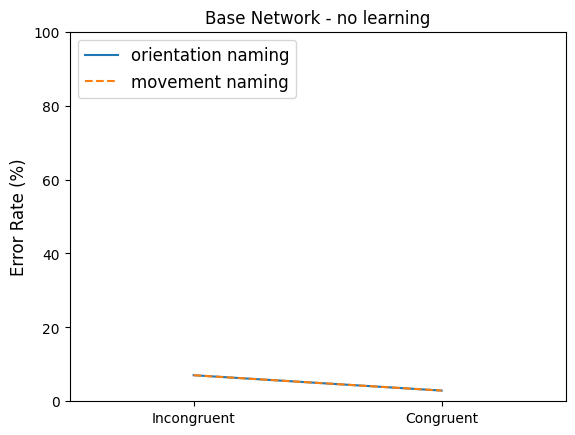

{'o_congruent': array([[0.02893623, 0.97106377]]), 'o_incongruent': array([[0.0704724, 0.9295276]]), 'm_congruent': array([[0.97106377, 0.02893623]]), 'm_incongruent': array([[0.0704724, 0.9295276]])}


In [ ]:
#### PLOT THE BASE NETWORK PERFORMANCE WITHOUT LEARNING ####
# Use the above defined conditions to determine the response probabilities from the Network
responses = simulate_trials(conditions)

# Compute the error rates
error_rates = compute_error_rates(conditions, responses)

# Visualize the error rates
plot_error_rates(error_rates, "Base Network - no learning")

print(responses)


Generating Training Data and and training the models (Backprop and Oja). Simulate trials for each model and plot the results (once for learning trajectory, once only for final weight).

In [ ]:
#### GENERATE TRAINING DATA ####
training_data = Network.generate_training_data(1000)

Epoch0/100, Average Loss: [[0.00352425 0.00352425]]
epoch 0 :  {'o_congruent': 0.3973899330718458, 'o_incongruent': 0.42850345984968197, 'm_congruent': 0.47359198057223884, 'm_incongruent': 0.4461558731699824}
Epoch25/100, Average Loss: [[0.00352464 0.00352464]]
epoch 25 :  {'o_congruent': 0.39738005507604135, 'o_incongruent': 0.428493326620624, 'm_congruent': 0.47359289032955776, 'm_incongruent': 0.4461550465401105}
Epoch50/100, Average Loss: [[0.00352503 0.00352503]]
epoch 50 :  {'o_congruent': 0.39737014398044357, 'o_incongruent': 0.42848316442596845, 'm_congruent': 0.4735937987984763, 'm_incongruent': 0.44615420944735673}
Epoch75/100, Average Loss: [[0.00352542 0.00352542]]
epoch 75 :  {'o_congruent': 0.3973601997052918, 'o_incongruent': 0.4284729731853899, 'm_congruent': 0.47359470598135767, 'm_incongruent': 0.44615336188560517}


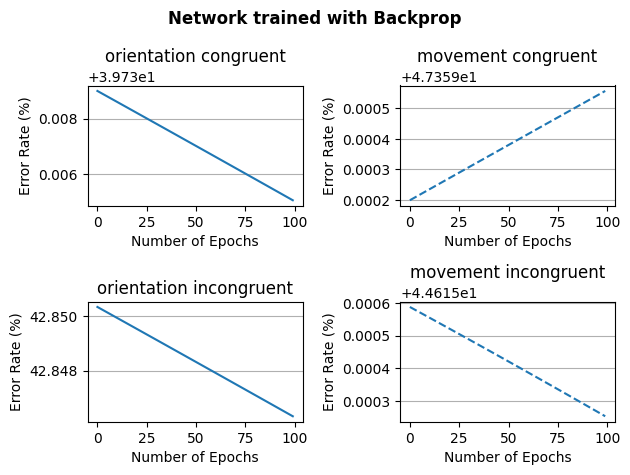

In [ ]:
#### TRAIN NETWORK WITH BACKPROP AND PLOT THE RESULTS ####
MSE_log, trained_weights, errors_list = Network.train_backprop(training_data, learning_rate = 0.001, conditions=conditions)
plot_error_rates_time(errors_list, "Network trained with Backprop")

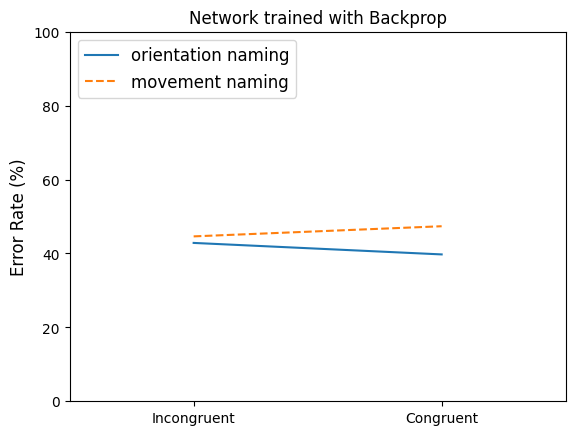

In [ ]:
#### RESULTS OF ONLY THE LAST SET OF WEIGHTS (COMPLETELY TRAINED NETWORK) ####
responses = simulate_trials(conditions, weights = trained_weights)
error_rates = compute_error_rates(conditions, responses)
plot_error_rates(error_rates, "Network trained with Backprop")

Epoch0/100, Average Loss: [[4.7765028e-11 4.7765028e-11]]
epoch 0 :  {'o_congruent': 0.42951320471607424, 'o_incongruent': 0.4698014952540339, 'm_congruent': 0.42951353080040955, 'm_incongruent': 0.46980167857931987}
Epoch25/100, Average Loss: [[9.42017228e-08 9.42017228e-08]]
epoch 25 :  {'o_congruent': 0.4298914952841171, 'o_incongruent': 0.4699639248390004, 'm_congruent': 0.42989994018533617, 'm_incongruent': 0.4699686711775497}
Epoch50/100, Average Loss: [[3.67459905e-07 3.67459905e-07]]
epoch 50 :  {'o_congruent': 0.4302677112552643, 'o_incongruent': 0.4701254361550793, 'm_congruent': 0.43028421128108985, 'm_incongruent': 0.4701347070212323}
Epoch75/100, Average Loss: [[8.16841969e-07 8.16841969e-07]]
epoch 75 :  {'o_congruent': 0.4306418641251014, 'o_incongruent': 0.4702860347257045, 'm_congruent': 0.43066635606635484, 'm_incongruent': 0.47029979193294313}


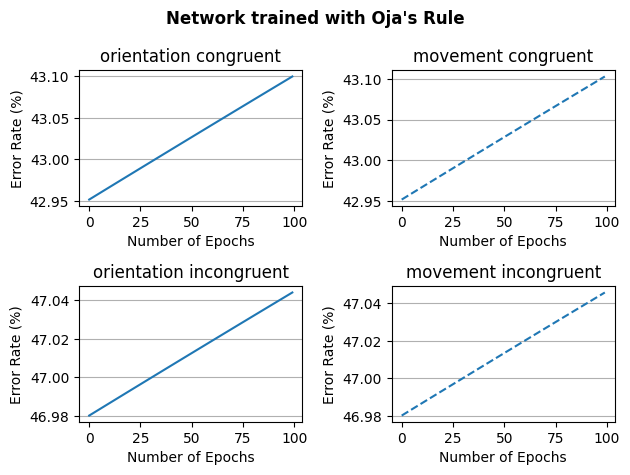

In [ ]:
#### TRAIN NETWORK WITH OJA AND PLOT THE RESULTS ####
MSE_log, trained_weights2, errors_list2 = Network.train_Oja(training_data, learning_rate = 0.001, conditions=conditions)
plot_error_rates_time(errors_list2, "Network trained with Oja's Rule")

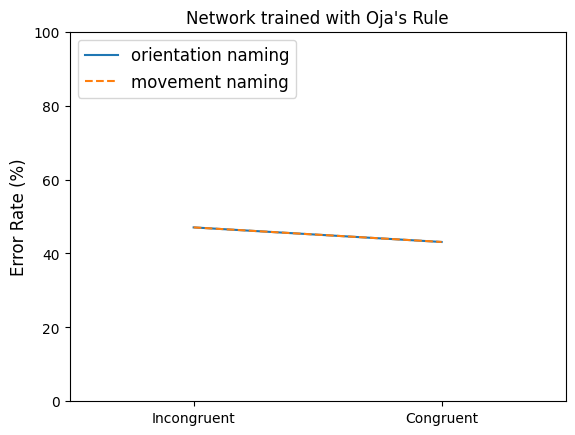

In [ ]:
#### RESULTS OF ONLY THE LAST SET OF WEIGHTS (COMPLETELY TRAINED NETWORK) ####
responses2 = simulate_trials(conditions, weights = trained_weights2)
error_rates2 = compute_error_rates(conditions,responses2)
plot_error_rates(error_rates2, "Network trained with Oja's Rule")

## Parameter Fitting *(4 points)*

For this exercise you should:

*   Set up a suitable parameter search space *(1 point)*

*   Implement a procedure to evaluate the fit of a model based on data *(2 points)*

*   Implement a procedure for searching the parameter space. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.



In [ ]:
#parameter search space
learning_rates = [0.001, 0.01, 0.1]

In [ ]:
# evaluate fit of a model based on maximum likelihood
def compute_log_likelihood(learning_rate, conditions, responses):
  '''
  This function computes the log likelihood for a given set of model parameters

  Input arguments:

    learning_rate (float):
    current learning rate being fitted

    conditions (dict):
     key value pairs where
     conditions["trial_name"] == (orientation_input, movement_input, task_input)

    responses (dict):
      key value pairs where
      responses["trial_name"] ==  [[ prob_left, prob_right ]]

  Returns:

    LL (float):
    total log likelihood of the predictions
  '''

  #initialize log likelihood
  LL = 0

  #get the error rates
  error_rates = compute_error_rates(conditions, responses)

  #get index for each response
  for name in responses.keys():

        #predicted probability for the false label
        error_probability = error_rates[name]

        # predicted probability for the true/target label
        true_probability = 1- error_probability

        #calculate log likelihood
        LL += np.log(true_probability)

  return LL

In [ ]:
#searching through parameter space
def param_search(learning_rates, conditions, responses):
  '''
  This function searches the parameter space and returns the best parameter and
  highest model log likelihood

  Input arguments:

    learning_rates (list):
      list of reasonable learning rate values

    conditions (dict):
     key value pairs where
     conditions["trial_name"] == (orientation_input, movement_input, task_input)

    responses (dict):
      key value pairs where
      responses["trial_name"] ==  [[ prob_left, prob_right ]]

    Returns:
      best_lr (float):
        the learning rate that yields the highest log-likelihood for the model
      best_LL (float):
        the highest log-likelihood that was reached
  '''

  best_LL = -200
  best_lr = 0

  #iterate through parameter options in a simple for loop (if there were more free parameters to fit this would equal grid search)
  for lr in learning_rates:

    #compute log likelihood
    log_likelihood = compute_log_likelihood(lr, conditions, responses)

    #store LL if it is higher than previous LL and its respective learning rate
    if log_likelihood > best_LL:
      best_LL = log_likelihood
      best_lr = lr

  return best_lr, best_LL

## Parameter Recovery *(5 points)*

For this exercise you should:

*   Set up a suitable space of parameters relevant for parameter recovery *(1 point)*

*   Use the functions above to generate behavior from a models, for a given set of (randomly sampled) parameters, and then fit the model to its generated data. Make sure to evaluate the parameter fit in a quantiative manner. *(3 points)*

*   Plot the parameter recovery results for both models. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





We first set up the number of trials for our training data, the number of true parameter values we want to recover and the range of simulated learning rates we want to recover.

In [ ]:
random.seed(1)

n_trials = 20

# the number of true values we seek to simulate
num_true_values = 20

###suitable space of parameters

# range of simulated and tested values for learning rates we want to recover
min_lr = 0.001
max_lr = 0.1

In this part we try to recover the parameters for the backpropagation model. We first randomly draw a learning rate between 0.001 and 0.1. with which we train our model. We then simulate a trial and use the response to fit the model to get the learning rate that best fits our data. We repeat this 20 times and store the true and the recovered learning rate for plotting.

In [ ]:
#### PARAMETER RECOVERY FOR MODEL 1 (Backpropagation)

# create arrays for logging
true_lr_log_model1 = np.zeros(num_true_values)

fitted_lr_log_model1 = np.zeros(num_true_values)

### generate behavior from model -> surrogate data

# for a number of randomly sampled parametrs
for run in range(num_true_values):

  # randomly sample model parameters
  true_lr_model1 = random.uniform(min_lr, max_lr)

  # log those parameters
  true_lr_log_model1[run] = true_lr_model1

  # simulate surrogate data

  training_data = Network.generate_training_data(n_trials)
  MSE_log, weights, results = Network.train_backprop(training_data=training_data, n_epochs=100, learning_rate=true_lr_model1, conditions=conditions)

  responses_model1 = simulate_trials(conditions, weights)

### fit model to generated data -> recover true parameters

  best_lr_model1, best_LL_model1 = param_search(learning_rates, conditions, responses_model1)

  #store fitted parameter (best fitting to data)
  fitted_lr_log_model1[run] = best_lr_model1

  print("Completed run " + str(run + 1) + " of " + str(num_true_values) + " for learning rate " + str(true_lr_model1))


Epoch0/100, Average Loss: [[0.00274776 0.00274776]]
epoch 0 :  {'o_congruent': 0.5193296372797113, 'o_incongruent': 0.5066806846836326, 'm_congruent': 0.48263025780946456, 'm_incongruent': 0.5499788826501467}
Epoch25/100, Average Loss: [[0.00274764 0.00274764]]
epoch 25 :  {'o_congruent': 0.519328759293908, 'o_incongruent': 0.5066807807520997, 'm_congruent': 0.4826284820882045, 'm_incongruent': 0.5499782357376668}
Epoch50/100, Average Loss: [[0.00274751 0.00274751]]
epoch 50 :  {'o_congruent': 0.5193278818430244, 'o_incongruent': 0.5066808768453588, 'm_congruent': 0.48262670785975537, 'm_incongruent': 0.5499775885853563}
Epoch75/100, Average Loss: [[0.00274738 0.00274738]]
epoch 75 :  {'o_congruent': 0.5193270049268776, 'o_incongruent': 0.5066809729634143, 'm_congruent': 0.4826249351224341, 'm_incongruent': 0.5499769411944357}
Completed run 1 of 20 for learning rate 0.014302060167127723
Epoch0/100, Average Loss: [[0.02032768 0.02032768]]
epoch 0 :  {'o_congruent': 0.35501457517728163, 

We do the same as above for our model with Hebbian learning:

In [ ]:
#### PARAMETER RECOVERY FOR MODEL 2 (hebbian/reinforcement learning)

# determine range of parameters for fitting
lr_values_model2 = np.linspace(min_lr, max_lr, 5)

# create  arrays for logging
true_lr_log_model2 = np.zeros(num_true_values)

fitted_lr_log_model2 = np.zeros(num_true_values)

### generate behavior from model -> surrogate data

# for a number of randomly sampled parametrs
for run in range(num_true_values):

  # randomly sample model parameters
  true_lr_model2 = random.uniform(min_lr, max_lr)

  # log those parameters
  true_lr_log_model2[run] = true_lr_model2

  # simulate surrogate data

  training_data = Network.generate_training_data(n_trials)
  MSE_log, weights, results = Network.train_Oja(training_data=training_data, conditions=conditions, n_epochs=100, learning_rate=true_lr_model2)

  responses_model2 = simulate_trials(conditions, weights)

### fit model to generated data -> recover true parameters

  best_lr_model2, best_LL_model2 = param_search(learning_rates, conditions, responses_model2)

  #store fitted parameter (best fitting to data)
  fitted_lr_log_model2[run] = best_lr_model2

  print("Completed run " + str(run + 1) + " of " + str(num_true_values) + " for learning rate " + str(true_lr_model2))

Epoch0/100, Average Loss: [[2.22159422e-10 2.22159422e-10]]
epoch 0 :  {'o_congruent': 0.5091916989760259, 'o_incongruent': 0.5147536096349864, 'm_congruent': 0.4848194756513513, 'm_incongruent': 0.5005475877658897}
Epoch25/100, Average Loss: [[5.87890269e-07 5.87890269e-07]]
epoch 25 :  {'o_congruent': 0.5085774172542444, 'o_incongruent': 0.5137327886698392, 'm_congruent': 0.485959778632979, 'm_incongruent': 0.5004792733104305}
Epoch50/100, Average Loss: [[2.13732357e-06 2.13732357e-06]]
epoch 50 :  {'o_congruent': 0.5080113087561811, 'o_incongruent': 0.5127887800226397, 'm_congruent': 0.48701656325429843, 'm_incongruent': 0.500418775066952}
Epoch75/100, Average Loss: [[4.42661839e-06 4.42661839e-06]]
epoch 75 :  {'o_congruent': 0.5074895774480462, 'o_incongruent': 0.5119159180490314, 'm_congruent': 0.48799565885649887, 'm_incongruent': 0.5003652299912275}
Completed run 1 of 20 for learning rate 0.025543654601411125
Epoch0/100, Average Loss: [[1.40716342e-13 1.40716342e-13]]
epoch 0 :

Here we use our stored values to plot the results for both models by comparing the fitted parameters to the true parameters. We also calculate the Pearson Correlation.

Pearson correlation coefficient for learning rate for backpropagation: -1.1357948138290244e-16
Pearson correlation coefficient for learning rate for hebbian learning: -1.5793724707085396e-16


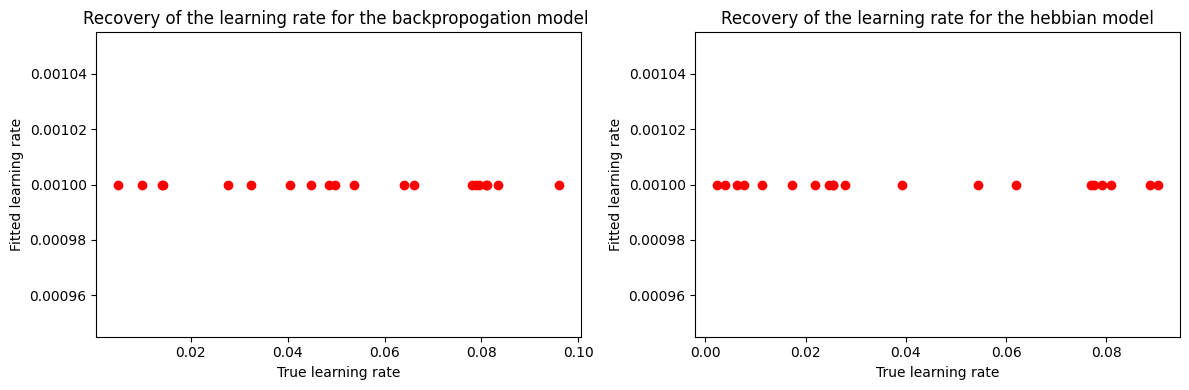

In [ ]:
### PLOTTING RESULTS OF PARAMETER RECOVERY

# Create subplots with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# scatter plot for backprop model
ax1.scatter(true_lr_log_model1, fitted_lr_log_model1, marker='o', color='red')
ax1.set_xlabel('True learning rate')
ax1.set_ylabel('Fitted learning rate')
ax1.set_title('Recovery of the learning rate for the backpropogation model ')

# scatter plot for hebbian model
ax2.scatter(true_lr_log_model2, fitted_lr_log_model2, marker='o', color='red')
ax2.set_xlabel('True learning rate')
ax2.set_ylabel('Fitted learning rate')
ax2.set_title('Recovery of the learning rate for the hebbian model')

# Adjust spacing between subplots
plt.tight_layout()

# Compute the Pearson correlation coefficient for lr for model 1
correlation_matrix_model1 = np.corrcoef(true_lr_log_model1, fitted_lr_log_model1)

# The correlation coefficient is at (0, 1) in the correlation matrix
correlation_model1 = correlation_matrix_model1[0, 1]
print(f"Pearson correlation coefficient for learning rate for backpropagation: {correlation_model1}")

# Compute the Pearson correlation coefficient for lr for model 2
correlation_matrix_model2 = np.corrcoef(true_lr_log_model2, fitted_lr_log_model2)

# The correlation coefficient is at (0, 1) in the correlation matrix
correlation_model2 = correlation_matrix_model2[0, 1]
print(f"Pearson correlation coefficient for learning rate for hebbian learning: {correlation_model2}")

## *Optional*: Model Recovery *(2 bonus points)*

In this bonus exercise, you may examine model reovery. The bonus points count towards your total group project points. That is, you may accumlate up to 22 points in the practical part of the group project.

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





Completed run 1 of 100
Epoch0/100, Average Loss: [[4.66780109e-05 4.66780109e-05]]
epoch 0 :  {'o_congruent': 0.5307754838865685, 'o_incongruent': 0.5312913252566545, 'm_congruent': 0.4653529600567585, 'm_incongruent': 0.5360486169577874}
Epoch25/100, Average Loss: [[4.6678004e-05 4.6678004e-05]]
epoch 25 :  {'o_congruent': 0.5307754842888882, 'o_incongruent': 0.531291322148814, 'm_congruent': 0.46535296567079165, 'm_incongruent': 0.5360486183606878}
Epoch50/100, Average Loss: [[4.6677997e-05 4.6677997e-05]]
epoch 50 :  {'o_congruent': 0.5307754846912083, 'o_incongruent': 0.5312913190409816, 'm_congruent': 0.4653529712848091, 'm_incongruent': 0.5360486197635892}
Epoch75/100, Average Loss: [[4.66779901e-05 4.66779901e-05]]
epoch 75 :  {'o_congruent': 0.5307754850935285, 'o_incongruent': 0.5312913159331578, 'm_congruent': 0.4653529768988107, 'm_incongruent': 0.5360486211664915}
Epoch0/100, Average Loss: [[4.66772703e-05 4.66772703e-05]]
epoch 0 :  {'o_congruent': 0.5307753644075324, 'o_i

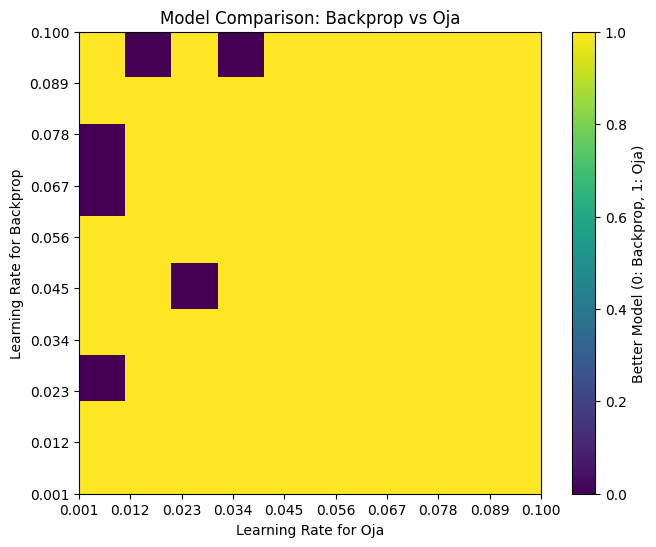

In [ ]:
# model recovery refers to the ability to correctly identify the true data generating model using model comparison techniques

import numpy as np
from sklearn.metrics import confusion_matrix

num_true_values = 10

# Define the models to be compared
models = ['backprop', 'oja']

# Define the true parameter values
true_lr_values = np.linspace(min_lr, max_lr, num_true_values)

# Initialize confusion matrix
conf_mat = np.zeros((num_true_values, num_true_values))

# Loop over true parameter values
for i in range(num_true_values):
    for j in range(num_true_values):
        print(f"Completed run {i*num_true_values+j+1} of {num_true_values*num_true_values}")

        # Simulate data from all models using the true parameter values
        training_data = Network.generate_training_data(n_trials)

        # Train each model on the simulated data
        MSE_log1, _, _ = Network.train_backprop(training_data=training_data, conditions=conditions, n_epochs=100, learning_rate=true_lr_values[i])
        MSE_log2, _, _ = Network.train_Oja(training_data=training_data, conditions=conditions, n_epochs=100, learning_rate=true_lr_values[j])

        # Compare the fits of each model to the data generated by the other models
        # Update confusion matrix
        # For simplicity, let's assume that the model with the lower MSE is considered to have a better fit
        if np.min(MSE_log1) < np.min(MSE_log2):  # Compare the final MSE values
          conf_mat[i, j] = 0  # Model 1 (backprop) is considered better
        else:
          conf_mat[i, j] = 1  # Model 2 (oja) is considered better

# Print confusion matrix
print("Confusion Matrix:")
print(conf_mat)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(conf_mat, cmap='viridis', origin='lower', extent=[min_lr, max_lr, min_lr, max_lr])
plt.colorbar(label='Better Model (0: Backprop, 1: Oja)')
plt.xlabel('Learning Rate for Oja')
plt.ylabel('Learning Rate for Backprop')
plt.title('Model Comparison: Backprop vs Oja')
plt.xticks(true_lr_values)
plt.yticks(true_lr_values)
plt.grid(False)
plt.show()

## Model Comparison *(5 points)*

For this exercise you should:

*   Load and (potentially) preprocess the experimental data. (1 point)

*   Fit the two models to the data.  *(1 point)*

*   Evaluate which model performs better, taking into account fit and model complexity. *(2 points)*

*   Plot the behavior of the winning model against the data. *(1 point)**

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





Saving experiment_data_Project.csv to experiment_data_Project (4).csv
These are the columns:/n Index(['rt', 'key_press', 'correct', 'coherent_movement_direction',
       'coherent_orientation', 'task_type', 'task_transition', 'congruency'],
      dtype='object')
Epoch0/100, Average Loss: [[0.00039053 0.00039053]]
epoch 0 :  {'o_congruent': 0.5496039658351992, 'o_incongruent': 0.5496933707082601, 'm_congruent': 0.5102424375230394, 'm_incongruent': 0.4895109334508281}
Epoch25/100, Average Loss: [[0.00039054 0.00039054]]
epoch 25 :  {'o_congruent': 0.5496048684370158, 'o_incongruent': 0.5496942856963037, 'm_congruent': 0.5102422801578002, 'm_incongruent': 0.4895110596062354}
Epoch50/100, Average Loss: [[0.00039054 0.00039054]]
epoch 50 :  {'o_congruent': 0.5496057721031806, 'o_incongruent': 0.549695201745534, 'm_congruent': 0.5102421228243774, 'm_incongruent': 0.48951118573762553}
Epoch75/100, Average Loss: [[0.00039055 0.00039055]]
epoch 75 :  {'o_congruent': 0.549606676834095, 'o_incong

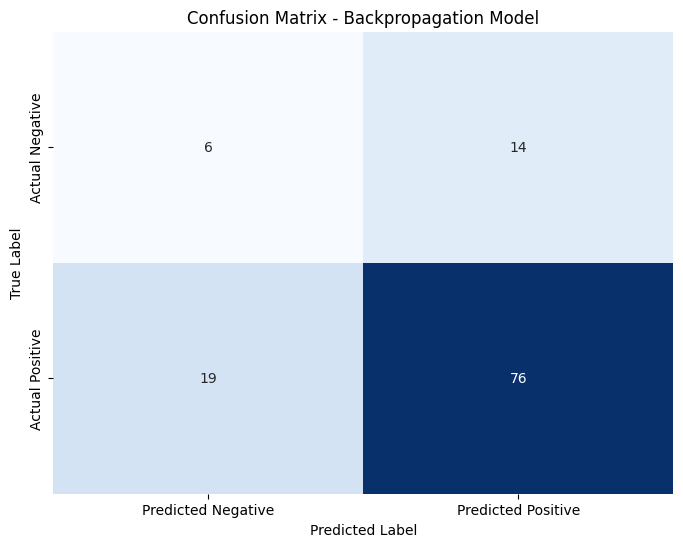

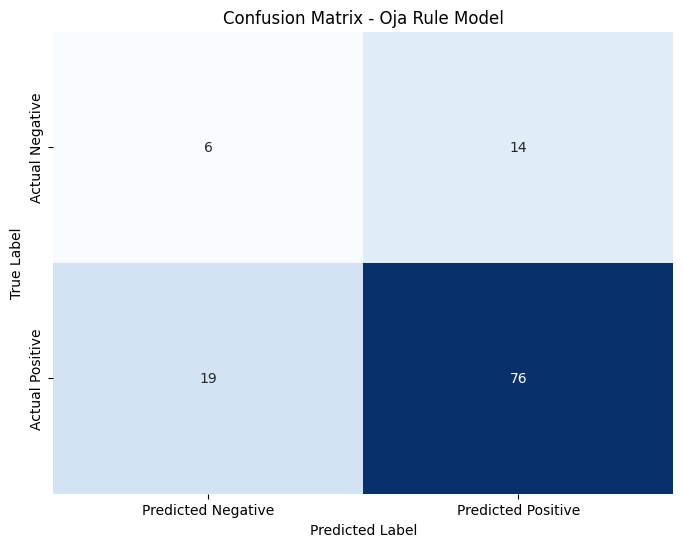

Epoch0/100, Average Loss: [[0.00102876 0.00102876]]
epoch 0 :  {'o_congruent': 0.5095113952155199, 'o_incongruent': 0.516936100508912, 'm_congruent': 0.43032110700837856, 'm_incongruent': 0.5500989414428151}
Epoch25/100, Average Loss: [[0.00102877 0.00102877]]
epoch 25 :  {'o_congruent': 0.5095115293303165, 'o_incongruent': 0.5169361614047493, 'm_congruent': 0.4303209461182941, 'm_incongruent': 0.550099272596451}
Epoch50/100, Average Loss: [[0.00102878 0.00102878]]
epoch 50 :  {'o_congruent': 0.5095116634640016, 'o_incongruent': 0.5169362223104086, 'm_congruent': 0.43032078520370665, 'm_incongruent': 0.5500996037952222}
Epoch75/100, Average Loss: [[0.00102879 0.00102879]]
epoch 75 :  {'o_congruent': 0.5095117976165776, 'o_incongruent': 0.5169362832258906, 'm_congruent': 0.4303206242646146, 'm_incongruent': 0.5500999350391338}
Epoch0/100, Average Loss: [[0.00102877 0.00102877]]
epoch 0 :  {'o_congruent': 0.5095117435542764, 'o_incongruent': 0.5169359707584711, 'm_congruent': 0.430322041

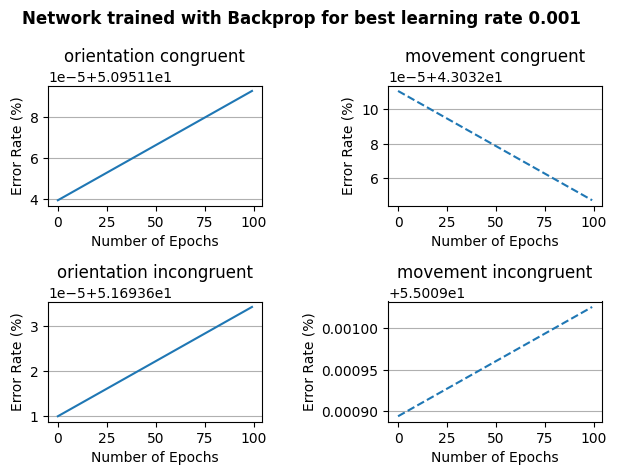

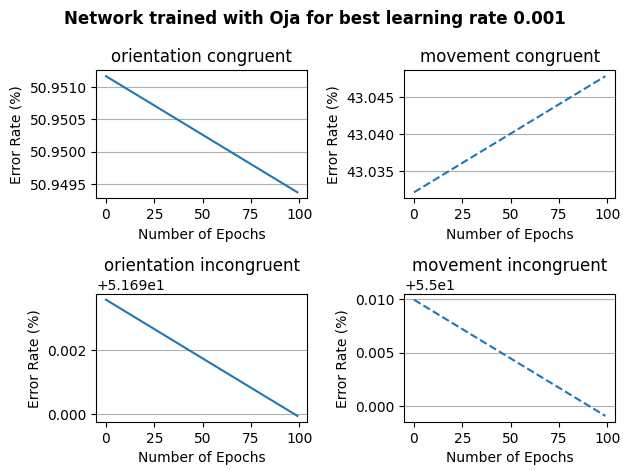

In [ ]:
from google.colab import files
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# open file dialog
uploaded = files.upload()

# load data
data = pd.read_csv("experiment_data_Project.csv",header=0, delimiter=";")

# define epochs
n_epochs = 100

###################
## PREPROCESSING ##
###################


# use only the columns which are important for us --> correct, task_type, coherent_orientation and coherent_movement_direction
data_preprocessed = data[['correct', 'coherent_orientation', 'coherent_movement_direction','task_type']]

# One-hot encoding task_type
data_preprocessed = pd.get_dummies(data_preprocessed, columns=['task_type'], prefix='task_type')

# Combine task_type_mov and task_type_or into one column
data_preprocessed['task_type'] = data_preprocessed.apply(lambda row: [row['task_type_mov'], row['task_type_or']], axis=1)
data_preprocessed.drop(['task_type_mov', 'task_type_or'], axis=1, inplace=True)

# One-hot encoding coherent_orientation and coherent_movement_direction
data_preprocessed['coherent_orientation'] = data_preprocessed['coherent_orientation'].apply(lambda x: [1, 0] if x == 180 else [0, 1])
data_preprocessed['coherent_movement_direction'] = data_preprocessed['coherent_movement_direction'].apply(lambda x: [0, 1] if x == 180 else [1, 0])

#print(data_preprocessed)



#############
## FITTING ##
#############

# Selecting features and target variable
X = data_preprocessed.drop(columns=['correct'])
y = data_preprocessed['correct']

# Splitting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# generate training data
training_data = Network.generate_training_data(n_trials=100)

# training
backprop_MSE_log, backprop_weights, _ = Network.train_backprop(training_data=training_data, conditions=conditions, n_epochs=100, learning_rate=0.01)

oja_MSE_log, oja_weights, _ = Network.train_Oja(training_data=training_data, conditions=conditions, n_epochs=100, learning_rate=0.01)



################
## EVALUATING ##
################

# prediction on the test set

#simulate_trials(conditions, weights=None)
backprop_preds = [Network.forward(int(X_test.iloc[i]['coherent_orientation'][0]), X_test.iloc[i]['coherent_movement_direction'][0], int(X_test.iloc[i]['task_type'][0]), return_activations=True, weights=backprop_weights)['out'] for i in range(len(X_test))]

oja_preds = [Network.forward(int(X_test.iloc[i]['coherent_orientation'][0]), X_test.iloc[i]['coherent_movement_direction'][0], int(X_test.iloc[i]['task_type'][0]), return_activations=True, weights=oja_weights)['out'] for i in range(len(X_test))]


#simulate responses

responses_backprop = {}
for i in range(len(X_test)):

  response = Network.forward(int(X_test.iloc[i]['coherent_orientation'][0]), X_test.iloc[i]['coherent_movement_direction'][0], int(X_test.iloc[i]['task_type'][0]), return_activations=True, weights=backprop_weights)['out']
  if int(X_test.iloc[i]['task_type'][0]) == [1][0]: #orientation
    if int(X_test.iloc[i]['coherent_orientation'][0]) == X_test.iloc[i]['coherent_movement_direction'][0]:
      responses_backprop['o_congruent'] = response
    else:
      responses_backprop['o_incongruent'] = response
  else:
    if int(X_test.iloc[i]['coherent_orientation'][0]) == X_test.iloc[i]['coherent_movement_direction'][0]:
      responses_backprop['m_congruent'] = response
    else:
      responses_backprop['m_incongruent'] = response


responses_oja = {}
for i in range(len(X_test)):

  response = Network.forward(int(X_test.iloc[i]['coherent_orientation'][0]), X_test.iloc[i]['coherent_movement_direction'][0], int(X_test.iloc[i]['task_type'][0]), return_activations=True, weights=oja_weights)['out']
  if int(X_test.iloc[i]['task_type'][0]) == [1][0]: #orientation
    if int(X_test.iloc[i]['coherent_orientation'][0]) == X_test.iloc[i]['coherent_movement_direction'][0]:
      responses_oja['o_congruent'] = response
    else:
      responses_oja['o_incongruent'] = response
  else:
    if int(X_test.iloc[i]['coherent_orientation'][0]) == X_test.iloc[i]['coherent_movement_direction'][0]:
      responses_oja['m_congruent'] = response
    else:
      responses_oja['m_incongruent'] = response




#fit the models
best_lr_backprop, _ = param_search(learning_rates, conditions, responses_backprop)
best_lr_oja, _ = param_search(learning_rates, conditions, responses_oja)


# Flatten the nested arrays of predictions
flat_backprop_preds = [pred[0][0] > pred[0][1] for pred in backprop_preds]
flat_oja_preds = [pred[0][0] > pred[0][1] for pred in oja_preds]

# Convert boolean values to integers (True -> 1, False -> 0)
flat_backprop_preds = [int(pred) for pred in flat_backprop_preds]
flat_oja_preds = [int(pred) for pred in flat_oja_preds]

# Calculate accuracies
backprop_accuracy = accuracy_score(y_test, flat_backprop_preds)
oja_accuracy = accuracy_score(y_test, flat_oja_preds)


print("Backpropagation Accuracy:", backprop_accuracy)
print("Oja Rule Accuracy:", oja_accuracy)


# model complexity
backprop_complexity = sum([param.shape[0] * param.shape[1] for param in [backprop_weights.o_in_to_o_h, backprop_weights.o_h_to_out, backprop_weights.m_in_to_m_h, backprop_weights.m_h_to_out]])
oja_complexity = sum([param.shape[0] * param.shape[1] for param in [oja_weights.o_in_to_o_h, oja_weights.o_h_to_out, oja_weights.m_in_to_m_h, oja_weights.m_h_to_out]])


print("Backpropagation Model Complexity:", backprop_complexity)
print("Oja's Rule Model Complexity:", oja_complexity)


##############
## PLOTTING ##
##############

# Calculate confusion matrix for backpropagation model
backprop_conf_matrix = confusion_matrix(y_test, flat_backprop_preds)

# Plot confusion matrix for backpropagation model
plt.figure(figsize=(8, 6))
sns.heatmap(backprop_conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False,
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.title("Confusion Matrix - Backpropagation Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Calculate confusion matrix for Oja rule model
oja_conf_matrix = confusion_matrix(y_test, flat_oja_preds)

# Plot confusion matrix for Oja rule model
plt.figure(figsize=(8, 6))
sns.heatmap(oja_conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False,
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.title("Confusion Matrix - Oja Rule Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# training
backprop_MSE_log, backprop_weights, backprop_weights_list = Network.train_backprop(training_data=training_data, conditions=conditions, n_epochs=100, learning_rate=best_lr_backprop)

# ojas rule model fitting
oja_MSE_log, oja_weights, oja_weights_list = Network.train_Oja(training_data=training_data, conditions=conditions, n_epochs=100, learning_rate=best_lr_oja)

print("fitted learning rate for Backpropagation: " + str(best_lr_backprop))
print("fitted learning rate for Oja's Rule: " + str(best_lr_oja))

plot_error_rates_time(backprop_weights_list,  "Network trained with Backprop for best learning rate 0.001")
plot_error_rates_time(oja_weights_list,  "Network trained with Oja for best learning rate 0.001")


###**Extra Function to plot the error rates (not learning trajectory) of Experiment Data**


In [ ]:
# open file dialog
from google.colab import files
import pandas as pd
uploaded = files.upload()
# load data
data = pd.read_csv("experiment_data_Project.csv",header=0,delimiter=";")

Saving experiment_data_Project.csv to experiment_data_Project (1).csv


In [ ]:
def plot_experiment_data(data):
  # only get
  congruence = data.congruency # incongruent congruent
  correctness = data.correct # True False
  task = data.task_type
  dat2 = list(zip(congruence, correctness, task))

  # Orientation
  count_con_o = 0
  count_inc_o = 0
  congruent_o = 0
  incongruent_o = 0
  # Movement
  count_con_m = 0
  count_inc_m = 0
  congruent_m = 0
  incongruent_m = 0


  for trial in dat2:
    # orientation
    if trial[0] == "congruent" and trial[2] == "or":
      congruent_o += 1
      if trial[1] == False:
        count_con_o += 1

    if trial [0] == "incongruent" and trial[2] == "or":
      incongruent_o += 1
      if trial[1] == False:
        count_inc_o += 1

    # movement
    if trial[0] == "congruent" and trial[2] == "mov":
      congruent_m += 1
      if trial[1] == False:
        count_con_m += 1

    if trial [0] == "incongruent" and trial[2] == "mov":
      incongruent_m += 1
      if trial[1] == False:
        count_inc_m += 1

  error_rate_con_o = (count_con_o / congruent_o) * 100
  error_rate_inc_o = (count_inc_o / incongruent_o) * 100

  error_rate_con_m = (count_con_m / congruent_m) * 100
  error_rate_inc_m = (count_inc_m / incongruent_m) * 100

  x_data = [0.5, 1.5]
  y_data_o = [error_rate_inc_o, error_rate_con_o]
  y_data_m = [error_rate_inc_m, error_rate_con_m]

  x_limit = [0,2]
  y_limit = [0, 100]
  x_label = "Condition"
  y_label = "Error Rate (%)"
  legend = ('orientation naming', 'movement naming')

  plt.plot(x_data, y_data_o, label=legend[0])
  plt.plot(x_data, y_data_m, '--', label=legend[1])
  plt.xlim(x_limit)
  plt.ylim(y_limit)
  plt.ylabel(y_label, fontsize="large")
  plt.legend(loc=2, fontsize="large")
  plt.xticks([0.5, 1.5], ['Incongruent', 'Congruent'],rotation=0)
  plt.show()
  return

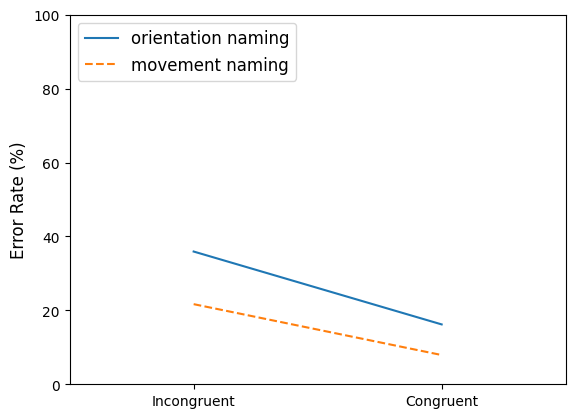

In [ ]:
plot_experiment_data(data)